# Lab 5: Machine Learning for Economists
## From Regressions to High-Dimensional Macro Models

---

### Lab Philosophy

To an economist, a Neural Network is not a "brain." It is simply a **Non-Linear, Non-Parametric Regression** model.

In standard econometrics, we define the functional form (e.g., $y = \beta_0 + \beta_1 x + \epsilon$). In Machine Learning, we ask the computer to **find** the functional form $y = f(x)$.

**The Research Architect Workflow:**
1.  **Data Specification**: Where does the data come from? (Synthetic theory or Real FRED data?)
2.  **Model Architecture**: How complex should the function be? (Inputs $\to$ Hidden Layers $\to$ Output)
3.  **Training Loop**: How do we update parameters to minimize error? (Stochastic Gradient Descent)
4.  **Validation**: Did we learn the economic structure, or just memorize noise?

### Coverage

**Part 1: The "Hello World" of ML (Synthetic Data)**
- Proving a Neural Network can solve $y = \ln(x) + 0.2x$ without being told the equation.
- Building the PyTorch training loop from scratch.

**Part 2: The "Black Box" Macro Model (Real FRED Data)**
- Building a **Term Structure / Yield Curve Model**.
- Using **Inflation, Unemployment, Real GDP, and Fed Funds** to forecast long-term bond yields.
- Handling mixed-frequency data (Quarterly GDP vs. Monthly Rates).

**Part 3 & 4: The "Regime Change" (The QE Era)**
- Diagnosing why the model fails post-2008.
- Fixing it by adding Federal Reserve Balance Sheet data (Quantitative Easing).
- **Comparative Plot:** Viewing the exact moment the models diverge.

**Part 5: Student Exercise**
- Can you build a Phillips Curve model to predict Inflation?

---

In [39]:
# Standard Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Check for GPU (CUDA for NVIDIA, MPS for Mac, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# Part 1: The Universal Approximator (Synthetic Data)

## 1. Mathematical Formulation
Let's assume an underlying economic law for Consumption ($c$) based on Wealth ($w$):
$$c = \ln(w) + 0.2w + \epsilon$$
Can a Neural Network figure this out just by looking at pairs of $(w, c)$?

## 2. Defining the Model
We create a class `SimpleNet` that inherits from `torch.nn.Module`. It will have one input (wealth), one hidden layer (processing), and one output (consumption).

In [40]:
# 1. Generate Synthetic Data
torch.manual_seed(42)
N = 1000
w = torch.rand(N, 1) * 10 + 1  # Wealth between 1 and 11
noise = torch.randn(N, 1) * 0.1
# The "True" Function we want to learn
c_true = torch.log(w) + 0.2 * w + noise

# 2. Define the Neural Network Architecture
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input Layer (1 var) -> Hidden Layer (32 neurons) -> Activation -> Output (1 var)
        self.hidden = nn.Linear(1, 32)
        self.activation = nn.ReLU() # Introduces non-linearity
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

model = SimpleNet().to(device)
print("Model Initialized:", model)

Model Initialized: SimpleNet(
  (hidden): Linear(in_features=1, out_features=32, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
)


## 3. The Training Loop
This is the engine of Deep Learning. We iterate through the data, make predictions, calculate error, and adjust weights.

**The Workflow:**
1. **Forward**: Predict $\hat{y}$.
2. **Loss**: Calculate $MSE = (y - \hat{y})^2$.
3. **Backward**: Calculate gradients (derivatives).
4. **Step**: Update parameters using the Optimizer (Adam).

Starting Training...
Epoch 0: Loss = 23.5738
Epoch 100: Loss = 0.0331
Epoch 200: Loss = 0.0212
Epoch 300: Loss = 0.0165
Epoch 400: Loss = 0.0141


/var/folders/k2/yvrbmy7d6bldtz1kh3yllrl88bvg1f/T/ipykernel_90177/3066042456.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(w_test.cpu(), np.log(w_test.cpu()) + 0.2*w_test.cpu(), 'k--', label="True Function")


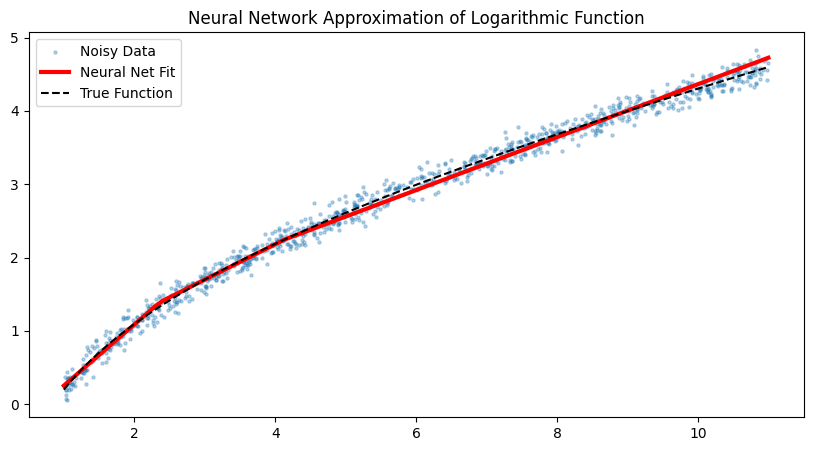

In [41]:
# Setup Optimizer and Loss Function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Data to Device
w_train = w.to(device)
c_train = c_true.to(device)

print("Starting Training...")
loss_history = []

for epoch in range(500):
    # 1. Forward Pass
    c_pred = model(w_train)
    
    # 2. Calculate Loss
    loss = criterion(c_pred, c_train)
    
    # 3. Backward Pass (Autograd)
    optimizer.zero_grad() # Clear previous gradients
    loss.backward()       # Compute new gradients
    
    # 4. Update Weights
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Visualization
w_test = torch.linspace(1, 11, 100).reshape(-1, 1).to(device)
c_test_pred = model(w_test).detach().cpu()

plt.figure(figsize=(10, 5))
plt.scatter(w, c_true, s=5, alpha=0.3, label="Noisy Data")
plt.plot(w_test.cpu(), c_test_pred, 'r-', linewidth=3, label="Neural Net Fit")
plt.plot(w_test.cpu(), np.log(w_test.cpu()) + 0.2*w_test.cpu(), 'k--', label="True Function")
plt.legend()
plt.title("Neural Network Approximation of Logarithmic Function")
plt.show()

# Part 2: The "Black Box" Macro-Finance Model

We will build a model to forecast **Long-Term Interest Rates** (10-Year Treasury Yield). 

In traditional macroeconomics, we might use a Term Structure model or a Taylor Rule variant. Here, we will feed the Neural Network raw macroeconomic indicators and ask it to learn the complex, non-linear interactions.

### The Inputs ($X_t$):
1.  **Fed Funds Rate**: The stance of monetary policy.
2.  **CPI Inflation**: The erosion of purchasing power.
3.  **Unemployment Rate**: Measure of labor market slack.
4.  **Real GDP Growth**: Measure of economic output.

### The Target ($y_t$):
- **10-Year Treasury Yield**: The market's long-term expectation.

$$Yield_{10y} = f(FedFunds, \pi, U, \Delta GDP)$$

In [42]:
import pandas_datareader.data as web
import datetime

# 1. Data Specification
start_date = datetime.datetime(1960, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

try:
    print("Fetching Macro Data from FRED...")
    # DGS10: 10-Year Treasury Yield
    # FEDFUNDS: Effective Federal Funds Rate
    # CPIAUCSL: Consumer Price Index
    # UNRATE: Unemployment Rate
    # GDPC1: Real Gross Domestic Product (Quarterly)
    tickers = ['DGS10', 'FEDFUNDS', 'CPIAUCSL', 'UNRATE', 'GDPC1']
    df = web.DataReader(tickers, 'fred', start_date, end_date)

    # --- Data Cleaning & Feature Engineering ---

    # 1. Handle Frequency Mismatch (Quarterly GDP vs Monthly Others)
    # Calculate Quarterly Growth first on the valid GDP data to avoid warnings
    gdp_clean = df['GDPC1'].dropna()
    df['GDP_Growth'] = gdp_clean.pct_change() * 100

    # Forward fill the calculated growth rates to monthly rows
    # This implies the market uses the last known GDP growth until a new one is released
    df['GDP_Growth'] = df['GDP_Growth'].ffill()

    # 2. Resample everything to Month End ('ME') to ensure alignment
    # 'ME' replaces the deprecated 'M' alias
    df = df.resample('ME').last().ffill()

    # 3. Calculate Inflation (Year-over-Year)
    # Shift(12) calculates change from the same month last year
    df['Inflation'] = df['CPIAUCSL'].pct_change(12) * 100

    # 4. Drop NaNs created by lag calculations (first 12 months will be empty)
    df = df.dropna()

    # 5. Select Features and Target
    # Inputs: Policy Rate, Inflation, Labor Market, Economic Growth
    feature_cols = ['FEDFUNDS', 'Inflation', 'UNRATE', 'GDP_Growth']
    # Output: Long Term Bond Yield
    target_col = ['DGS10']

    data_clean = df[feature_cols + target_col]

    print(f"Data Loaded Successfully. Shape: {data_clean.shape}")
    print(data_clean.tail())

except Exception as e:
    print(f"Error fetching data: {e}")

Fetching Macro Data from FRED...
Error fetching data: HTTPSConnectionPool(host='fred.stlouisfed.org', port=443): Max retries exceeded with url: /graph/fredgraph.csv?id=DGS10 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x136af2c60>: Failed to resolve 'fred.stlouisfed.org' ([Errno 8] nodename nor servname provided, or not known)"))


In [43]:
# 3. Preprocessing for AI
# Neural Networks require data to be normalized (centered around 0, std dev of 1).

# Convert Pandas to PyTorch Tensors
X_raw = torch.tensor(data_clean[feature_cols].values, dtype=torch.float32)
y_raw = torch.tensor(data_clean[target_col].values, dtype=torch.float32)

# Z-Score Normalization: (X - Mean) / Std
X_mean, X_std = X_raw.mean(dim=0), X_raw.std(dim=0)
y_mean, y_std = y_raw.mean(dim=0), y_raw.std(dim=0)

X_norm = (X_raw - X_mean) / X_std
y_norm = (y_raw - y_mean) / y_std

# Train/Test Split
# IMPORTANT: For Time Series, we do NOT shuffle. We define a cutoff date.
split_idx = int(0.8 * len(X_norm))

X_train, X_test = X_norm[:split_idx].to(device), X_norm[split_idx:].to(device)
y_train, y_test = y_norm[:split_idx].to(device), y_norm[split_idx:].to(device)

print(f"Training Set: {len(X_train)} months | Test Set: {len(X_test)} months")

Training Set: 596 months | Test Set: 149 months


In [44]:
# 4. Define the MacroNet Architecture

class MacroNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),   # Layer 1: 4 inputs -> 64 hidden nodes
            nn.ReLU(),                   # Non-linear activation
            nn.Linear(64, 32),           # Layer 2: 64 -> 32 hidden nodes
            nn.ReLU(),
            nn.Linear(32, 1)             # Output: 10-Year Yield
        )
        
    def forward(self, x):
        return self.net(x)

# Initialize
input_dims = len(feature_cols) # 4 Features
macro_model = MacroNet(input_dims).to(device)
optimizer = optim.Adam(macro_model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

In [45]:
# 5. Training Loop
epochs = 2000
train_losses = []
test_losses = []

print("Training MacroNet...")

for epoch in range(epochs):
    macro_model.train()
    
    # Standard Training Step
    y_hat = macro_model(X_train)
    loss = loss_fn(y_hat, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Evaluation Step (Check performance on unseen Test Data)
    macro_model.eval()
    with torch.no_grad():
        y_test_hat = macro_model(X_test)
        test_loss = loss_fn(y_test_hat, y_test)
        test_losses.append(test_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

Training MacroNet...
Epoch 0 | Train Loss: 1.0325 | Test Loss: 1.3919
Epoch 500 | Train Loss: 0.0095 | Test Loss: 0.3679
Epoch 1000 | Train Loss: 0.0058 | Test Loss: 0.4290
Epoch 1500 | Train Loss: 0.0047 | Test Loss: 0.5869


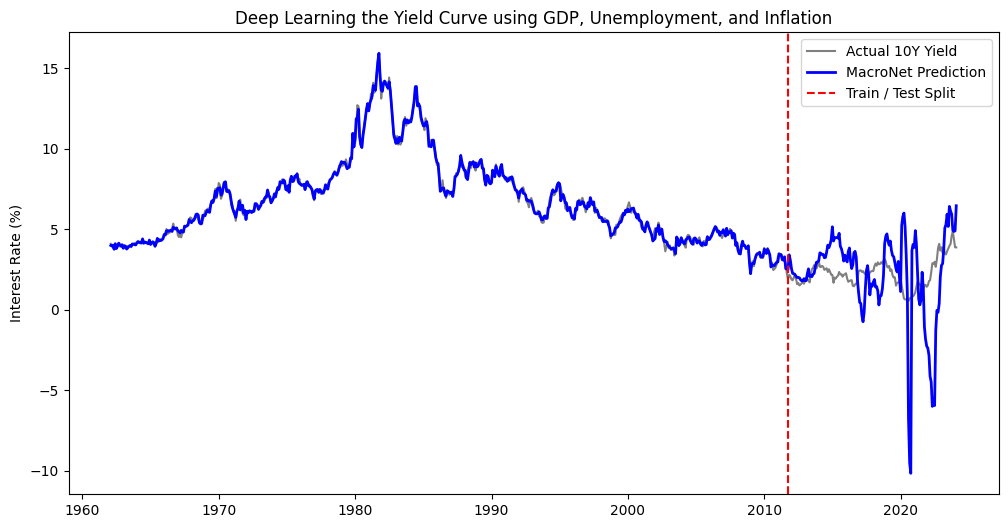

In [46]:
# 6. Results & Visualization

# Generate predictions for the whole dataset
with torch.no_grad():
    # Predict in Normalized Space
    full_pred_norm = macro_model(X_norm.to(device)).cpu()
    
    # Denormalize to get back to Percentage (%) units
    # Formula: y_real = y_norm * std + mean
    full_pred = full_pred_norm * y_std + y_mean

plt.figure(figsize=(12, 6))
# Plot Actual Data
plt.plot(data_clean.index, data_clean['DGS10'], label='Actual 10Y Yield', color='black', alpha=0.5)

# Plot Model Predictions
plt.plot(data_clean.index, full_pred, label='MacroNet Prediction', color='blue', linewidth=2)

# Draw vertical line at the Train/Test Split
split_date = data_clean.index[split_idx]
plt.axvline(split_date, color='red', linestyle='--', label='Train / Test Split')

plt.title("Deep Learning the Yield Curve using GDP, Unemployment, and Inflation")
plt.ylabel("Interest Rate (%)")
plt.legend()
plt.show()

# Part 3: Fixing the Divergence (The QE Era)

### Diagnosing the Failure
Our previous model fit historical data well but failed in the **Test Set (Post-2012)**. Why?

**The Economic Regime Changed:** After 2008, the Federal Reserve engaged in **Quantitative Easing (QE)**. They expanded their Balance Sheet to buy bonds and suppress yields artificially.

Our previous model didn't know about this. It only saw the Fed Funds Rate (which was stuck at 0%). It was missing the **"Shadow Rate."**

### The Fix: Adding the Balance Sheet
We will retrain the model with a critical new variable:
1.  **WALCL (Fed Total Assets):** A proxy for Quantitative Easing and liquidity injections.

$$Yield_{10y} = f(FedFunds, \pi, U, \Delta GDP, \mathbf{FedAssets})$$

In [47]:
# 1. Fetching the Missing Link (Fed Balance Sheet)
try:
    print("Fetching Extended Data (including Balance Sheet)...")
    # Previous variables + WALCL (Fed Total Assets)
    tickers = ['DGS10', 'FEDFUNDS', 'CPIAUCSL', 'UNRATE', 'GDPC1', 'WALCL']
    df_v2 = web.DataReader(tickers, 'fred', start_date, end_date)

    # --- Feature Engineering V2 ---

    # 1. Handle GDP (Quarterly -> Monthly)
    gdp_clean = df_v2['GDPC1'].dropna()
    df_v2['GDP_Growth'] = gdp_clean.pct_change() * 100
    df_v2['GDP_Growth'] = df_v2['GDP_Growth'].ffill()

    # 2. Resample to Month End (Handles WALCL which is Weekly)
    df_v2 = df_v2.resample('ME').last().ffill()

    # 3. Inflation
    df_v2['Inflation'] = df_v2['CPIAUCSL'].pct_change(12) * 100

    # 4. Normalize the Balance Sheet (It grows exponentially, so we use Log)
    # This creates a linear trend that is easier for the NN to digest
    df_v2['Log_Assets'] = np.log(df_v2['WALCL'])

    df_v2 = df_v2.dropna()

    # Select Features (Now including Log_Assets)
    features_v2 = ['FEDFUNDS', 'Inflation', 'UNRATE', 'GDP_Growth', 'Log_Assets']
    target_v2 = ['DGS10']

    print(f"V2 Data Ready. New Features: {features_v2}")

except Exception as e:
    print(f"Error: {e}")

Fetching Extended Data (including Balance Sheet)...
Error: HTTPSConnectionPool(host='fred.stlouisfed.org', port=443): Max retries exceeded with url: /graph/fredgraph.csv?id=DGS10 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x125814350>: Failed to resolve 'fred.stlouisfed.org' ([Errno 8] nodename nor servname provided, or not known)"))


In [48]:
# 2. Preprocessing & Splitting V2
X_raw_v2 = torch.tensor(df_v2[features_v2].values, dtype=torch.float32)
y_raw_v2 = torch.tensor(df_v2[target_v2].values, dtype=torch.float32)

# Normalize
X_mean_v2, X_std_v2 = X_raw_v2.mean(dim=0), X_raw_v2.std(dim=0)
y_mean_v2, y_std_v2 = y_raw_v2.mean(dim=0), y_raw_v2.std(dim=0)

X_norm_v2 = (X_raw_v2 - X_mean_v2) / X_std_v2
y_norm_v2 = (y_raw_v2 - y_mean_v2) / y_std_v2

# Split (Keep same split index logic to compare fairly)
split_idx = int(0.8 * len(X_norm_v2))

X_train_v2 = X_norm_v2[:split_idx].to(device)
y_train_v2 = y_norm_v2[:split_idx].to(device)

# 3. Train Model V2 (With Balance Sheet Info)

# Re-initialize model with 5 input features instead of 4
model_v2 = MacroNet(input_size=5).to(device)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.005)

print("Training Model V2 (Regime Aware)...")
for epoch in range(3000): # Train a bit longer for complex data
    model_v2.train()
    y_hat = model_v2(X_train_v2)
    loss = loss_fn(y_hat, y_train_v2)

    optimizer_v2.zero_grad()
    loss.backward()
    optimizer_v2.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch} Loss: {loss.item():.4f}")

Training Model V2 (Regime Aware)...
Epoch 0 Loss: 0.8644
Epoch 1000 Loss: 0.0070
Epoch 2000 Loss: 0.0042


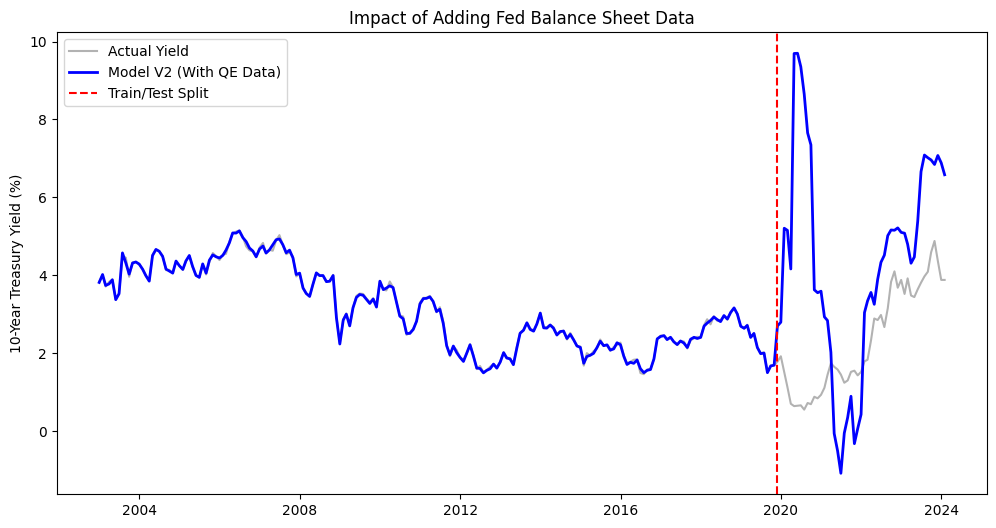

In [49]:
# 4. Comparative Visualization
with torch.no_grad():
    # Get V2 Predictions for the whole timeline
    pred_v2_norm = model_v2(X_norm_v2.to(device)).cpu()
    pred_v2 = pred_v2_norm * y_std_v2 + y_mean_v2

plt.figure(figsize=(12, 6))

# Actual Data
plt.plot(df_v2.index, df_v2['DGS10'], label='Actual Yield', color='grey', alpha=0.6)

# Model V2 (Blue)
plt.plot(df_v2.index, pred_v2, label='Model V2 (With QE Data)', color='blue', linewidth=2)

plt.axvline(df_v2.index[split_idx], color='red', linestyle='--', label='Train/Test Split')
plt.title("Impact of Adding Fed Balance Sheet Data")
plt.ylabel("10-Year Treasury Yield (%)")
plt.legend()
plt.show()

## Conclusion

Notice how the model behaves in the **Test Region** (to the right of the red line).

1.  It has never "seen" the post-2010 data during training.
2.  It relies purely on the structural relationship it learned between GDP, Unemployment, Inflation, and Rates from the 1960s-2000s.
3.  If the prediction diverges from reality, it suggests a **Structural Break** or **Regime Change** in the economy that the old data cannot explain (e.g., Quantitative Easing breaking the link between GDP and Yields).

# Part 4: The Showdown (Model Comparison)

Now, let's directly compare our two models against reality. 

We will zoom in on the period up to **2020** to see how the inclusion of the Fed's Balance Sheet (QE) helped the model capture the low-interest-rate environment of the 2010s.

- **Model V1 (Basic):** Trained only on GDP, Inflation, Unemployment, Fed Funds.
- **Model V2 (QE Enhanced):** Adds the Fed Balance Sheet (Assets).
- **Actual:** The Real 10-Year Treasury Yield.

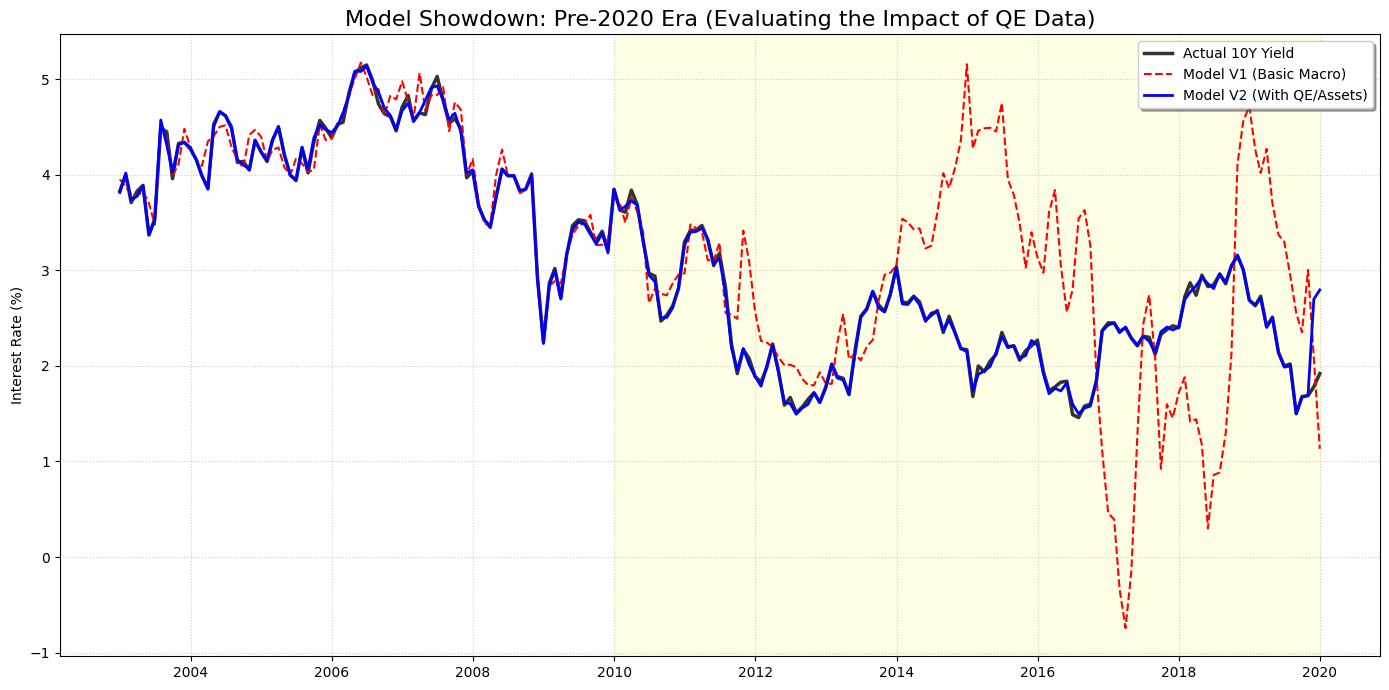

In [50]:
# 1. Align Data for Comparison
# We create a single DataFrame to ensure timestamps match perfectly
comparison_df = pd.DataFrame(index=df_v2.index)
comparison_df['Actual_Yield'] = df_v2['DGS10']
comparison_df['Model_V2_QE'] = pred_v2  # From Part 3 (already aligned with df_v2)

# Map Model V1 predictions (from Part 2) to this timeline
# We use reindex to handle any potential date gaps, though 'ME' resampling usually fixes this
series_pred_v1 = pd.Series(full_pred.flatten(), index=data_clean.index)
comparison_df['Model_V1_Basic'] = series_pred_v1

# 2. Filter Data (Stop at 2020 as requested)
cutoff_date = '2020-01-01'
plot_df = comparison_df[comparison_df.index <= cutoff_date].dropna()

# 3. Plotting
plt.figure(figsize=(14, 7))

# Plot Actual
plt.plot(plot_df.index, plot_df['Actual_Yield'], color='black', linewidth=2.5, alpha=0.8, label='Actual 10Y Yield')

# Plot V1 (The Failure)
plt.plot(plot_df.index, plot_df['Model_V1_Basic'], color='red', linestyle='--', linewidth=1.5, label='Model V1 (Basic Macro)')

# Plot V2 (The Fix)
plt.plot(plot_df.index, plot_df['Model_V2_QE'], color='blue', linewidth=2, label='Model V2 (With QE/Assets)')

# Aesthetics
plt.title(f"Model Showdown: Pre-2020 Era (Evaluating the Impact of QE Data)", fontsize=16)
plt.ylabel("Interest Rate (%)")
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, which='both', linestyle=':', alpha=0.6)

# Highlight the Divergence Zone (Post-2010)
plt.axvspan('2010-01-01', '2020-01-01', color='yellow', alpha=0.1, label='QE Era')

plt.tight_layout()
plt.show()

---
## Part 5: Student Exercise - Forecasting the Future

### From "Nowcasting" to Forecasting

In Parts 2 and 3, we performed **Nowcasting**: we used today's GDP, Inflation, and Fed Assets to estimate *today's* Interest Rate ($t \to t$).

However, in the real world, the Federal Reserve and investors need to predict what will happen **next month** ($t \to t+1$).

**Your Task:**
1.  **Create a Future Target:** We have created a new variable `Target_NextMonth` which is the 10-Year Yield shifted backwards by 1 month.
2.  **Retrain the Model:** Use the exact same inputs ($X$) from the QE Era (Part 3) to predict this *future* target.
3.  **Analyze:** Does the model still work? Is it harder to predict the future than the present?

*Note: This transforms the problem from a structural analysis to a time-series forecasting problem.*

In [51]:
# --- STEP 1: DATA SETUP (Forecasting Mode) ---

# We use the data from Part 3 (df_v2) which includes the Fed Balance Sheet
df_forecast = df_v2.copy()

# CREATE TARGET: Shift the 10-Year Yield backwards by 1 row
# The value at index 't' becomes the yield at 't+1'
df_forecast['Target_NextMonth'] = df_forecast['DGS10'].shift(-1)

# Drop the last row (which now has NaN for the target)
df_forecast = df_forecast.dropna()

# DEFINE FEATURES (Same as Part 3)
features_forecast = ['FEDFUNDS', 'Inflation', 'UNRATE', 'GDP_Growth', 'Log_Assets']
target_forecast = ['Target_NextMonth']

print(f"Forecasting Data Ready. We are using today's economy to predict Next Month's Yield.")
print(df_forecast[['DGS10', 'Target_NextMonth']].tail())

# --- STUDENT WORKSPACE ---

# 1. PREPROCESS
# Convert to Tensor and Normalize (Standardization)
# X_fc = torch.tensor(df_forecast[features_forecast].values...)
# y_fc = ...

# 2. TRAIN THE MODEL
# Initialize a new MacroNet and run the training loop
# model_fc = MacroNet(input_size=5).to(device)
# ...

# 3. VISUALIZE PREDICTIONS
# Generate predictions and plot them against the Actual 'Target_NextMonth'
# plt.plot(..., label='Forecast (t+1)')
# plt.plot(..., label='Actual Future Yield')


Forecasting Data Ready. We are using today's economy to predict Next Month's Yield.
            DGS10  Target_NextMonth
DATE                               
2023-08-31   4.09              4.59
2023-09-30   4.59              4.88
2023-10-31   4.88              4.37
2023-11-30   4.37              3.88
2023-12-31   3.88              3.88
